## Dependencies

In [1]:
import os, sys, six, pimms, pandas
import numpy as np
import scipy as sp
import torch

import matplotlib as mpl
import matplotlib.pyplot as plt

# This assumes that you ar running the notebook from in
# the directory that contains the sfp-optimize library
# (which is True if you are using the github repository)
# or that you have put the sfp-optimize library on your
# python path.
import sfpopt

## Testing the Optimization

In [3]:
# Optimization parameters and rounds:
image0 = 'radial'
imsize = 384
knob = 6.0
lr0 = 0.075
rounds = [{'steps': 10000,  'lr': lr0},
          {'steps': 10000,  'lr': lr0/2},
          {'steps': 10000,  'lr': lr0/4}]
# Store results in these lists (one entry per round):
(imaps, thetas, omegas, phis, images, betas) = ([], [], [], [], [], [])
lossvals = []
for (ii,r) in enumerate(rounds):
    im0 = image0 if len(phis) == 0 else phis[-1]
    imap = sfpopt.plan(direction=im0, image_size_px=imsize, knob=knob,
                       tracking=lossvals, **r)
    image_phi0 = imap['image_phi0_deg']
    ang = imap['image_angle_rad']
    ecc = imap['image_eccen_deg']
    if ii == 0:
        im = torch.tensor(np.array(image_phi0))
        (th,om) = sfpopt.image_sfstats(im)
        bb = sfpopt.beta(ang, ecc, th, om, imap['model_params'])
        bb = bb.detach().numpy()
        phis.append(image_phi0)
        thetas.append(th.detach().numpy())
        omegas.append(om.detach().numpy())
        images.append(np.cos(image_phi0))
        betas.append(bb)
        print("Start: ", np.var(bb))
    im = imap['image'] # Force calculation
    imph = imap['image_phi_deg']
    (th,om) = sfpopt.image_sfstats(imph)
    bb = sfpopt.beta(ang, ecc, th, om, imap['model_params'])
    phis.append(imph.detach().numpy())
    thetas.append(th.detach().numpy())
    omegas.append(om.detach().numpy())
    betas.append(bb.detach().numpy())
    images.append(im)
    imaps.append(imap)
    print("Round: ", np.var(betas[-1]))

pass

Start:  0.00015579163
Round:  5.5689674e-05
Round:  1.4183168e-05
Round:  4.19125e-06


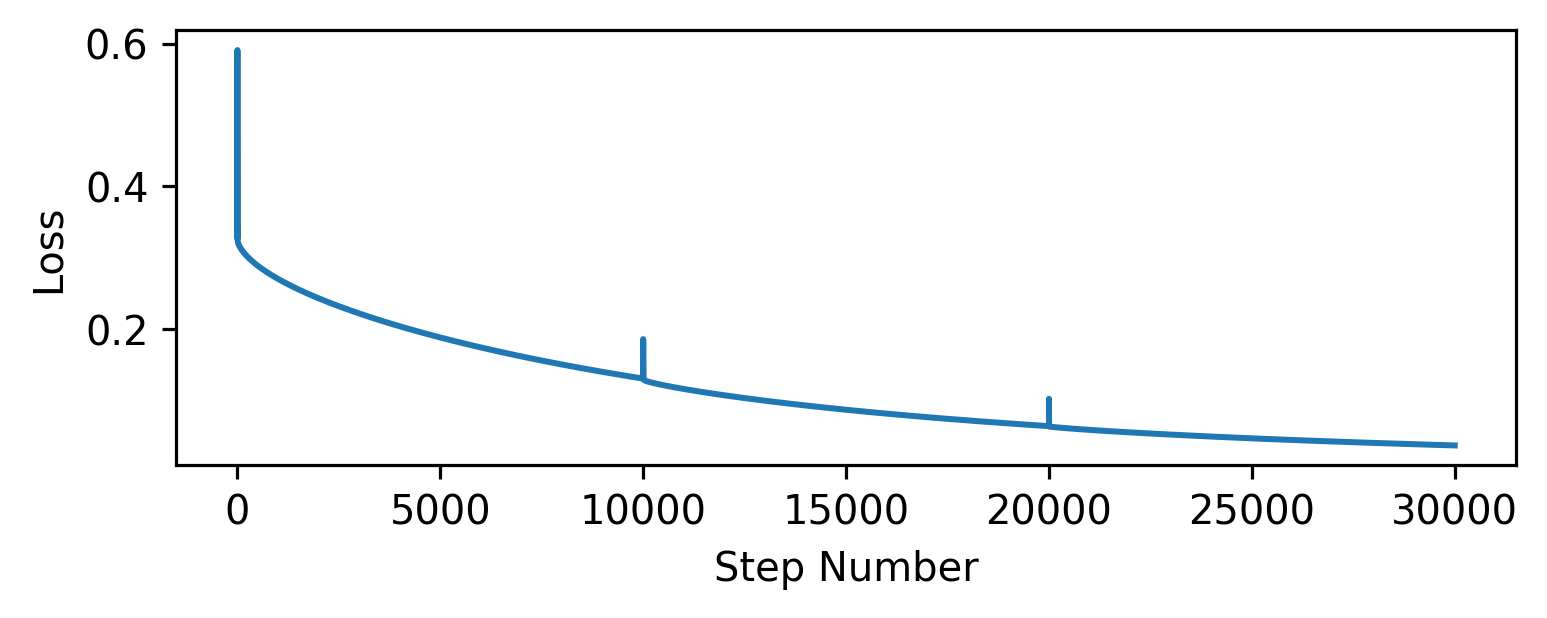

In [21]:
(fig,ax) = plt.subplots(1,1, figsize=(6,2), dpi=72*4, sharey=True)
ax.plot(lossvals)
ax.set_ylabel('Loss')
ax.set_xlabel('Step Number')
pass

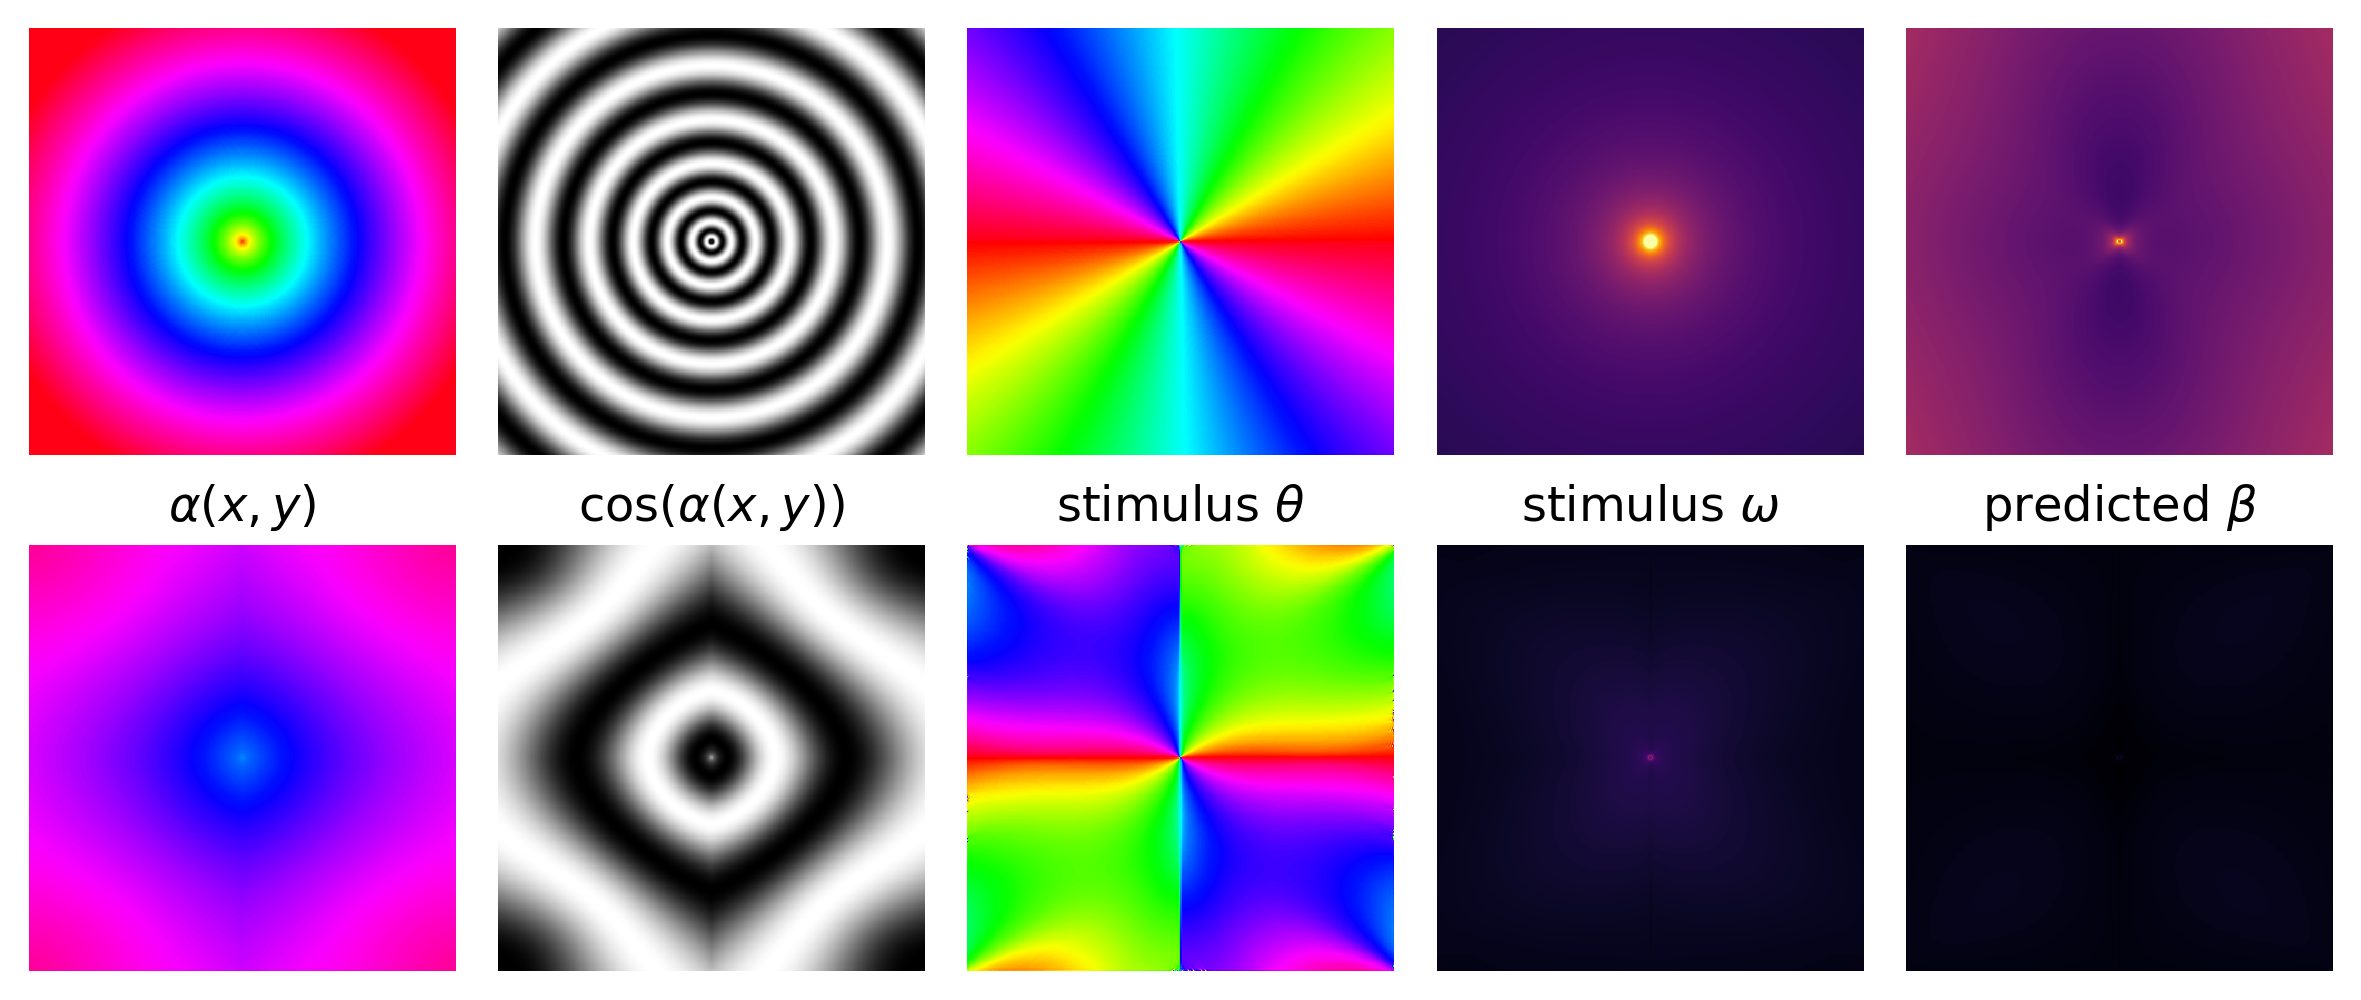

In [25]:
(fig,axs) = plt.subplots(2,5, figsize=(8,3.5), dpi=72*4)
fig.subplots_adjust(0,0,1,1,0.1,0.05)
bmin = np.min([betas[0], betas[-1]])
bmax = np.max([betas[0], betas[-1]])
for k in [0,-1]:
    axs[k,0].imshow(phis[k], cmap='hsv', vmin=0, vmax=45)
    axs[k,0].axis('off')
    axs[k,1].imshow(images[k], cmap='gray', vmin=-1, vmax=1)
    axs[k,1].axis('off')
    #th = np.mod(2*thetas[k]+np.pi/2, np.pi) - np.pi/2
    th = np.mod(thetas[k], np.pi)
    axs[k,2].imshow(th, cmap='hsv', vmin=0, vmax=np.pi)
    axs[k,2].axis('off')
    axs[k,3].imshow(omegas[k], cmap='inferno', vmin=0, vmax=0.1)
    axs[k,3].axis('off')
    #print(k, sfpopt.loss_smoothness(th, True), sfpopt.loss_smoothness(omegas[k], False))
    axs[k,4].imshow(betas[k], cmap='inferno', vmin=bmin, vmax=bmax)
    axs[k,4].axis('off')
axs[1,0].set_title(r'$\alpha(x,y)$')
axs[1,1].set_title(r'$\cos\left(\alpha(x,y)\right)$')
axs[1,2].set_title(r'stimulus $\theta$')
axs[1,3].set_title(r'stimulus $\omega$')
axs[1,4].set_title(r'predicted $\beta$')
pass

## Comparison to prediction results coded up separately

In [26]:
import neuropythy as ny
import pickle

p = {}
for name in ['flat', 'paper', 'scaling', 'simple']:
    with open('/home/nben/tmp/sfp-preds/task-sfprescaled_params-%s_predicted-bold.pkl' % name, 'rb') as fl:
        p[name] = pickle.load(fl)

pass

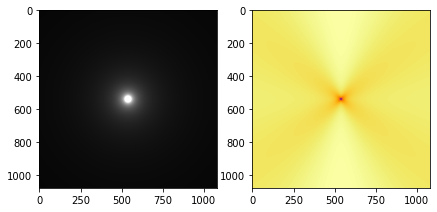

In [52]:
pp = p['paper']

#stims = pp['stimuli']
stims = pp['stimuli_spatial_frequency']
preds = pp['predicted_bold']

ii = 6
im = stims[ii]
imsz = im.shape[0]
# Make a prediction using the sfpopt model; first we
# find eccen and angle for each pixel.
x = np.linspace(-12.4, 12.4, imsz)
(x,y) = np.meshgrid(x, x)
ang = np.arctan2(y, x)
ecc = np.sqrt(x**2 + y**2)
# Eep! need the theta and omega, but can't easily derive this from the image.
#bpred = beta()

(fig,axs) = plt.subplots(1,2, figsize=(7,3.5))
axs[0].imshow(stims[ii], cmap='gray', vmin=0, vmax=4)
axs[1].imshow(preds[ii], cmap='inferno')

pass